In [2]:
import numpy as np
import gymnasium as gym # Updated import for gym
from gymnasium import spaces
from scipy.stats import norm
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import time

In [ ]:
class AirQualityDiscreteEnv(gym.Env):
    def __init__(self):
        super(AirQualityDiscreteEnv, self).__init__()
        
        # New discrete action space: 0 = no change, 1 = increase by 0.1, 2 = decrease by 0.1
        self.action_space = spaces.Discrete(3)
        
        # State space: [AQI, fan voltage, time of day, effective Q]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0]),
            high=np.array([500, 5, 24, 100]),
            dtype=np.float32
        )
        
        # Fan parameters (5V DC fan)
        self.fan_voltage = 2.5  # Initial voltage (V)
        self.max_voltage = 5.0
        self.min_voltage = 0.0
        self.voltage_step = 0.1  # Voltage change per action
        self.voltage_to_speed = 1.0  # Conversion factor (m/s per volt)
        
        self.Q = 80  # Emission rate (μg/s)
        self.H = 1.5  # Effective stack height (m)
        self.y = 0    # Cross-wind distance (m)
        self.z = 1.2  # Receptor height (m)
        self.x = 2.0  # Downwind distance (m)
        
        self.stability_class = 'D'
        
        self.stability_params = {
            'A': {'σy': 0.22, 'σz': 0.20},
            'D': {'σy': 0.08, 'σz': 0.06},
            'F': {'σy': 0.04, 'σz': 0.03}
        }
        
        self.aqi_breakpoints = [
            (0, 12.0, 0, 50),
            (12.1, 35.4, 51, 100),
            (35.5, 55.4, 101, 150),
            (55.5, 150.4, 151, 200),
            (150.5, 250.4, 201, 300),
            (250.5, 500.4, 301, 500)
        ]
        
        self.time = 8.0  # Start at 8 AM
        self.time_step = 0.1  # 6-minute intervals
        
        self.fan_resistance = 10  # Ohms
        self.energy_coeff = 0.001  # Scaling factor for reward
        
    def _voltage_to_wind_speed(self, voltage):
        """Convert fan voltage to wind speed (m/s)"""
        return voltage * self.voltage_to_speed
    
    def _gaussian_plume_model(self, wind_speed):
        """Calculate pollutant concentration using Gaussian plume model"""
        params = self.stability_params[self.stability_class]
        σy = params['σy'] * self.x  # Downwind distance multiplier
        σz = params['σz'] * self.x

        # Prevent division by zero
        epsilon = 1e-6
        wind_speed = max(wind_speed, epsilon)
        σy = max(σy, epsilon)
        σz = max(σz, epsilon)
        
        # Simplified 3D Gaussian plume (centerline, so y=0)
        term1 = self.Q / (2 * np.pi * σy * σz * wind_speed)
        term2 = np.exp(-(self.z - self.H)**2 / (2 * σz**2))
        term3 = np.exp(-(self.z + self.H)**2 / (2 * σz**2))
        
        concentration = term1 * (term2 + term3)
        return max(concentration, 0.1)  # Prevent division by zero
    
    def _calculate_aqi(self, concentration):
        """Convert PM2.5 concentration to AQI"""
        for (c_low, c_high, i_low, i_high) in self.aqi_breakpoints:
            if c_low <= concentration <= c_high:
                return ((i_high - i_low)/(c_high - c_low)) * (concentration - c_low) + i_low
        return 500  # Beyond hazardous
    
    def _calculate_energy(self):
        """Calculate fan energy consumption (Joules)"""
        current = self.fan_voltage / self.fan_resistance
        power = self.fan_voltage * current
        return power * (self.time_step * 3600)  # Convert hours to seconds
    
    def step(self, action):
        """Execute one time step within the environment"""
        # Update stability class based on time of day
        if 6.0 <= self.time < 18.0:  # Daytime (6AM-6PM)
            self.stability_class = 'A'  # More turbulent
        else:  # Nighttime
            self.stability_class = 'F'  # More stable
        # Handle discrete actions
        if action == 1:  # Increase voltage
            self.fan_voltage = min(self.fan_voltage + self.voltage_step, self.max_voltage)
        elif action == 2:  # Decrease voltage
            self.fan_voltage = max(self.fan_voltage - self.voltage_step, self.min_voltage)
        # Else action == 0: no change
        wind_speed = self._voltage_to_wind_speed(self.fan_voltage)
        source_variation = 1 + 0.5 * np.sin(2 * np.pi * self.time/24)
        effective_Q = self.Q * source_variation
        
        concentration = self._gaussian_plume_model(wind_speed)
        aqi = self._calculate_aqi(concentration)
        energy = self._calculate_energy()
        
        self.time = (self.time + self.time_step) % 24
        
        # Reward function
        aqi_error = abs(aqi - 50)  # Target AQI 50
        reward = (1 / (1 + 0.1*aqi_error)) - self.energy_coeff * energy
        
        state = np.array([aqi, self.fan_voltage, self.time, effective_Q], dtype=np.float32)
        done = self.time < 0.1 
        terminated = self.time < 0.1  # End of the day
        truncated = False 
        return state, reward, terminated, truncated, {
                                                    'concentration': concentration,
                                                    'energy': energy,
                                                    'wind_speed': wind_speed,
                                                    'episode': {  # For automatic logging
                                                        'r': reward, 
                                                        'l': self.time_step
                                                    }
                                                }
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Required for Gymnasium
        self.fan_voltage = 2.5
        self.time = 8.0
        state = np.array([
            self._calculate_aqi(self._gaussian_plume_model(2.5)),
            self.fan_voltage,
            self.time,
            self.Q
        ], dtype=np.float32)
        return state, {}

    
    def render(self, mode='human'):
        wind_speed = self._voltage_to_wind_speed(self.fan_voltage)
        concentration = self._gaussian_plume_model(wind_speed)
        hours = int(self.time)
        minutes = int((self.time % 1) * 60)
        print(f"Voltage: {self.fan_voltage:.2f}V | Wind: {wind_speed:.2f}m/s | "
              f"PM2.5: {concentration:.2f}μg/m³ | AQI: {self._calculate_aqi(concentration):.0f} | Time: {hours:02d}:{minutes:02d}")

In [15]:
# Example usage with random actions
if __name__ == "__main__":
    env = AirQualityDiscreteEnv()
    obs = env.reset()
    
    # Test with random control
    for i in range(100):
        # Generate random action between [0,1, 2]
        # time.sleep(1)
        action = env.action_space.sample()
        
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        
        print(f"Step {i+1}: Action={action} | Reward={reward:.3f} | Energy={info['energy']:.2f}J")
        
        if terminated or truncated:
            print("Resetting environment after full day cycle")
            obs = env.reset()

Voltage: 2.50V | Wind: 2.50m/s | PM2.5: 11.65μg/m³ | AQI: 49 | Time: 08:05
Step 1: Action=0 | Reward=0.649 | Energy=225.00J
Voltage: 2.50V | Wind: 2.50m/s | PM2.5: 11.65μg/m³ | AQI: 49 | Time: 08:11
Step 2: Action=0 | Reward=0.649 | Energy=225.00J
Voltage: 2.40V | Wind: 2.40m/s | PM2.5: 12.14μg/m³ | AQI: 51 | Time: 08:17
Step 3: Action=2 | Reward=0.695 | Energy=207.36J
Voltage: 2.30V | Wind: 2.30m/s | PM2.5: 12.67μg/m³ | AQI: 52 | Time: 08:23
Step 4: Action=2 | Reward=0.630 | Energy=190.44J
Voltage: 2.40V | Wind: 2.40m/s | PM2.5: 12.14μg/m³ | AQI: 51 | Time: 08:29
Step 5: Action=1 | Reward=0.695 | Energy=207.36J
Voltage: 2.40V | Wind: 2.40m/s | PM2.5: 12.14μg/m³ | AQI: 51 | Time: 08:35
Step 6: Action=0 | Reward=0.695 | Energy=207.36J
Voltage: 2.30V | Wind: 2.30m/s | PM2.5: 12.67μg/m³ | AQI: 52 | Time: 08:41
Step 7: Action=2 | Reward=0.630 | Energy=190.44J
Voltage: 2.20V | Wind: 2.20m/s | PM2.5: 13.24μg/m³ | AQI: 53 | Time: 08:47
Step 8: Action=2 | Reward=0.572 | Energy=174.24J
Voltage:

In [16]:
from stable_baselines3 import PPO
import os

In [17]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
            self.model.save(model_path)
        
        # Log episode info when done
        if 'episode' in self.locals['infos'][0]:
            ep_reward = self.locals['infos'][0]['episode']['r']
            ep_length = self.locals['infos'][0]['episode']['l']
            self.logger.record('episode/reward', ep_reward)
            self.logger.record('episode/length', ep_length)
        
        return True
    
CHECKPOINT_DIR = './ppo/train/'
LOG_DIR = './ppo/logs/'
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [18]:
# Create and wrap the environment
# Initialize DQN model with more reasonable parameters
env = AirQualityDiscreteEnv()
model = PPO(
    'MlpPolicy', 
    env, 
    tensorboard_log=LOG_DIR, 
    verbose=1,
    n_steps=2048,        # Number of steps to run for each environment per update
    batch_size=64,       # Minibatch size
    n_epochs=10,         # Number of epoch when optimizing the surrogate loss
    gamma=0.99,          # Discount factor
    gae_lambda=0.95,     # Factor for trade-off of bias vs variance for GAE
    ent_coef=0.01,       # Entropy coefficient
    learning_rate=3e-4,  # Learning rate
    clip_range=0.2,      # Clipping parameter
)
# Set up and attach custom logger
new_logger = configure(LOG_DIR, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)

# Train the model
model.learn(total_timesteps=100000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo/logs/
---------------------------------
| episode/           |          |
|    length          | 0.1      |
|    reward          | -0.046   |
| rollout/           |          |
|    ep_len_mean     | 0.1      |
|    ep_rew_mean     | -0.078   |
| time/              |          |
|    fps             | 7578     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| episode/                |             |
|    length               | 0.1         |
|    reward               | 0.394       |
| rollout/                |             |
|    ep_len_mean          | 1.7         |
|    ep_rew_mean          | 1.03        |
| time/                   |             |
|    fps                  | 4666        |
|    iterations           | 2           |
|    time_elapsed    

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
logs = pd.read_csv('./ppo/logs/progress.csv')

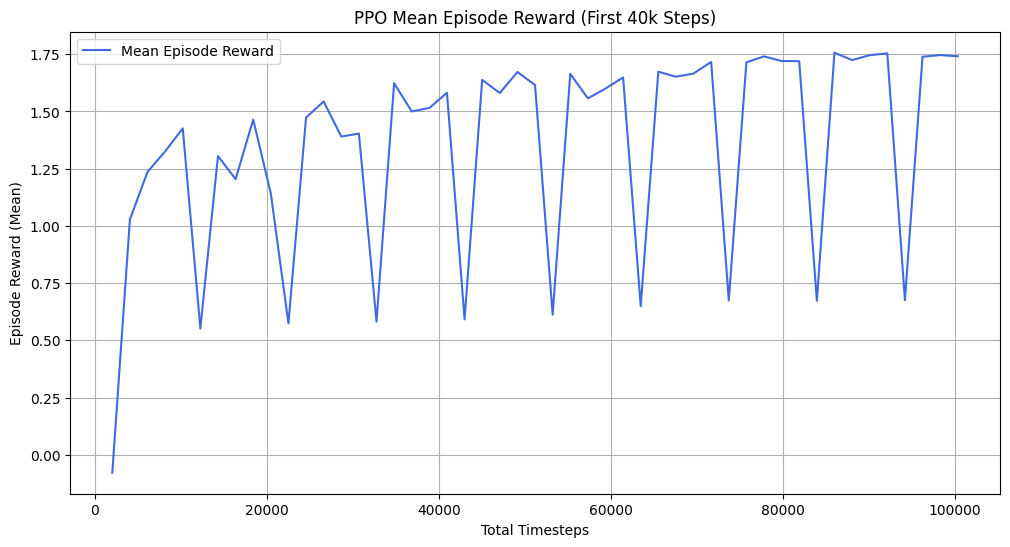

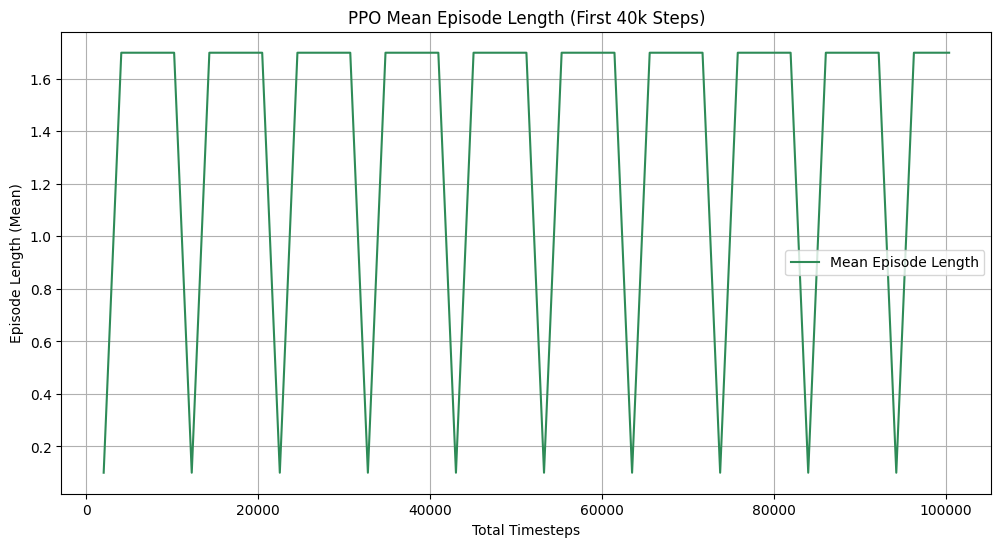

In [20]:
# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_rew_mean'], label='Mean Episode Reward', color='royalblue')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('PPO Mean Episode Reward (First 40k Steps)')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_len_mean'], label='Mean Episode Length', color='seagreen')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Length (Mean)')
plt.title('PPO Mean Episode Length (First 40k Steps)')
plt.grid(True)
plt.legend()
plt.show()